In [1]:
import torch
import numpy as np
import random

In [2]:
seed = 42
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)

# Define Model

In [3]:
from utils.DevConf import DevConf
DEV_CONF = DevConf(device='cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
from utils.AttnBlocksConf import AttnBlocksConf
from model.BertDecoder.SentiClassifier import SentiClassifier
from model.CombinationModel import CombinationModel
from utils.const import BlockType

c:\Users\User\miniconda3\envs\NLP\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
mapper = SentiClassifier(6, AttnBlocksConf(768, 12, nKVHead=6), BlockType.CROSS, devConf=DEV_CONF)
model = CombinationModel(nClass=6, decoder=mapper, devConf=DEV_CONF)

# Load Data

In [6]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-multilingual-cased", cache_dir='./cache/tokenizer')

In [7]:
import pandas as pd

In [8]:
train = pd.read_csv('data/archive/train.csv')

In [9]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split

In [10]:
class MyDataset(Dataset):
    def __init__(self, df, tokenizer):
        self.df = df
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # print(idx)
        text = self.df.iloc[idx]['ABSTRACT']
        label = torch.tensor([self.df.iloc[idx][i] for i in ["Computer Science","Physics","Mathematics","Statistics","Quantitative Biology","Quantitative Finance"]])
        return text, label
        # return self.tokenizer(text, return_tensors='pt', padding='max_length', truncation=True, max_length=128), label

In [11]:
def collect_fn(batch):
    texts, labels = zip(*batch)
    # print(texts)
    return tokenizer(texts, return_tensors='pt', padding='max_length', truncation=True, max_length=512).to(device=DEV_CONF.device), torch.stack(labels).to(DEV_CONF.device)

In [12]:
# def seed_worker(worker_id):
#     worker_seed = torch.initial_seed() % 2**32
#     np.random.seed(worker_seed)
#     random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)

In [13]:
dataset = MyDataset(train, tokenizer)

datasize = len(dataset)
splitIndex = int(datasize * 0.2)
trainDataSize = datasize - splitIndex

train_dataset, test_dataset = random_split(dataset, [trainDataSize, splitIndex])

train_loader = DataLoader(
    train_dataset, collate_fn=collect_fn, batch_size=8, shuffle=True,
    generator=g)
test_loader = DataLoader(
    test_dataset, collate_fn=collect_fn, batch_size=1, shuffle=True,
    generator=g)

In [14]:
print(trainDataSize, splitIndex)

16778 4194


# Train

In [15]:
from torch import nn
from torch.utils.tensorboard import SummaryWriter

In [16]:
lr = 1e-5
epochs = 1
loss_fn = nn.BCELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

In [17]:
def train_fn(model, train_loader, loss_fn, optimizer, epochs):
    model.train()
    writer = SummaryWriter()
    for epoch in range(epochs):
        for i, (data, label) in enumerate(train_loader):
            # print(data['input_ids'])
            # break
            optimizer.zero_grad()
            output = model(**data, NoGradBert=False)
            label = label.repeat(1, 2)
            label = label.view(label.shape[0], 2, -1)
            label = label.mT
            label[:, :, 0] = 1 - label[:, :, 0]
            loss = loss_fn(output, label.float())
            loss.backward()
            optimizer.step()
            if i % 100 == 99:
                print(f"Epoch {epoch+1}/{epochs} - Batch {i+1}/{len(train_loader)} - Loss: {loss.item()}")
                writer.add_scalar('Loss/train', loss.item(), i + 1)
    writer.flush()
    writer.close()

In [18]:
model.train()
train_fn(model, train_loader, loss_fn, optimizer, epochs)
print("Done")

Epoch 1/1 - Batch 100/2098 - Loss: 0.17408427596092224
Epoch 1/1 - Batch 200/2098 - Loss: 0.349831223487854
Epoch 1/1 - Batch 300/2098 - Loss: 0.19846908748149872
Epoch 1/1 - Batch 400/2098 - Loss: 0.3179100453853607
Epoch 1/1 - Batch 500/2098 - Loss: 0.3163294792175293
Epoch 1/1 - Batch 600/2098 - Loss: 0.1477564573287964
Epoch 1/1 - Batch 700/2098 - Loss: 0.11038359254598618
Epoch 1/1 - Batch 800/2098 - Loss: 0.0817776471376419
Epoch 1/1 - Batch 900/2098 - Loss: 0.19754886627197266
Epoch 1/1 - Batch 1000/2098 - Loss: 0.07008742541074753
Epoch 1/1 - Batch 1100/2098 - Loss: 0.14692696928977966
Epoch 1/1 - Batch 1200/2098 - Loss: 0.18761782348155975
Epoch 1/1 - Batch 1300/2098 - Loss: 0.301103800535202
Epoch 1/1 - Batch 1400/2098 - Loss: 0.16306591033935547
Epoch 1/1 - Batch 1500/2098 - Loss: 0.11036732792854309
Epoch 1/1 - Batch 1600/2098 - Loss: 0.24511092901229858
Epoch 1/1 - Batch 1700/2098 - Loss: 0.1485184133052826
Epoch 1/1 - Batch 1800/2098 - Loss: 0.3033134937286377
Epoch 1/1 -

# Eval

In [19]:
model.eval()

CombinationModel(
  (distilBert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1):

In [20]:
# id = 13
# sample = tokenizer(dataset[id][0], return_tensors='pt', padding='max_length', truncation=True, max_length=512).to(device=DEV_CONF.device)
# output = torch.where(model(**sample) > 0.5, 1, 0)
# print(output)
# print(dataset[id][1])
# array = output.to("cpu").squeeze().numpy()
# dataset_array = dataset[id][1].numpy()
# for i in range(6):
#     print(array[i], dataset_array[i])
# ans = torch.eq(output.to("cpu"), dataset[id][1])
# print(ans)
# print(torch.all(ans))

In [21]:
# acc = [0] * 6
# testdata = train.sample(1000)
# test_dataset = MyDataset(testdata, tokenizer)

# for data in test_dataset:
#     # print(data[1][0])
#     sample = tokenizer(data[0], return_tensors='pt', padding='max_length', truncation=True, max_length=512).to(device=DEV_CONF.device)
#     output = torch.where(model(**sample) > 0.5, 1, 0)
#     ansList = torch.eq(output.squeeze().to("cpu"), data[1])
#     for i, ans in enumerate(ansList):
#         # print(ans)
#         if ans:
#             acc[i] += 1

In [22]:
# print(acc)

In [23]:
# def test(model, test_loader):
#     acc = [[[0, 0], [0, 0]] for _ in range(6)]
#     for (data, label) in test_loader:
#         output = torch.where(model(**data) > 0.25, 1, 0).squeeze().cpu().numpy()
#         ans = label.squeeze().squeeze().cpu().numpy()
#         for i in range(6):
#             acc[i][output[i]][ans[i]] += 1
#     return acc

In [24]:
def test(model, test_loader):
    acc = [[[0, 0], [0, 0]] for _ in range(6)]
    for (data, label) in test_loader:
        output = torch.argmax(model(**data), dim=2).squeeze().cpu().numpy()
        ans = label.squeeze().squeeze().cpu().numpy()
        for i in range(6):
            acc[i][output[i]][ans[i]] += 1
    return acc

In [25]:
confuse_matrix = test(model, test_loader)

In [26]:
for matrix in confuse_matrix:
    print(matrix)

[[2151, 245], [342, 1456]]
[[2882, 160], [136, 1016]]
[[2919, 298], [117, 860]]
[[2886, 281], [228, 799]]
[[4061, 95], [13, 25]]
[[4141, 22], [13, 18]]


[[1606, 887], [66, 1635]]
[[2565, 453], [154, 1022]]
[[2581, 455], [179, 979]]
[[1836, 1278], [112, 968]]
[[4074, 0], [120, 0]]
[[4154, 0], [40, 0]]

[[1513, 980], [45, 1656]]
[[2438, 580], [114, 1062]]
[[2727, 309], [227, 931]]
[[2112, 1002], [155, 925]]
[[4074, 0], [120, 0]]
[[4154, 0], [40, 0]]

[[1885, 608], [102, 1599]]
[[2640, 378], [111, 1065]]
[[2581, 455], [143, 1015]]
[[2388, 726], [135, 945]]
[[4073, 1], [111, 9]]
[[4154, 0], [40, 0]]

[[1893, 600], [63, 1638]]
[[2732, 286], [99, 1077]]
[[2646, 390], [127, 1031]]
[[2474, 640], [59, 1021]]
[[4007, 67], [41, 79]]
[[4116, 38], [12, 28]]

[[1850, 643], [59, 1642]]
[[2556, 462], [54, 1122]]
[[2667, 369], [136, 1022]]
[[2804, 310], [180, 900]]
[[4018, 56], [44, 76]]
[[4145, 9], [27, 13]]

[[1870, 623], [108, 1593]]
[[2322, 696], [83, 1093]]
[[2450, 586], [107, 1051]]
[[2403, 711], [123, 957]]
[[4038, 36], [69, 51]]
[[4150, 4], [25, 15]]

[[1585, 908], [38, 1663]]
[[2578, 440], [111, 1065]]
[[2755, 281], [209, 949]]
[[2377, 737], [93, 987]]
[[4035, 39], [60, 60]]
[[4154, 0], [40, 0]]

[[1656, 837], [45, 1656]]
[[2680, 338], [144, 1032]]
[[2761, 275], [203, 955]]
[[2674, 440], [223, 857]]
[[4048, 26], [73, 47]]
[[4153, 1], [34, 6]]

In [27]:
microacc = [[0, 0], [0, 0]]
for i in range(6):
    for j in range(2):
        for k in range(2):
            microacc[j][k] += confuse_matrix[i][j][k]

In [28]:
print(microacc) # microaveraging, macroaveraging

[[19040, 1101], [849, 4174]]


[[16816, 3073], [671, 4604]]

[[17018, 2871], [701, 4574]]

[[17721, 2168], [642, 4633]]

[[17868, 2021], [401, 4874]]

[[18040, 1849], [500, 4775]]

[[17233, 2656], [515, 4760]]

[[17484, 2405], [551, 4724]]

[[17972, 1917], [722, 4553]]

In [54]:
macro = [{"Recall" : 0, "Precision" : 0, "F1" : 0, "Acc" : 0} for _ in range(len(confuse_matrix))]
for id, matrix in enumerate(confuse_matrix):
    macro[id]["Precision"] = matrix[1][1] / (matrix[1][1] + matrix[1][0])
    macro[id]["Recall"] = matrix[1][1] / (matrix[1][1] + matrix[0][1])
    macro[id]["F1"] = 2 * macro[id]["Recall"] * macro[id]["Precision"] / (macro[id]["Recall"] + macro[id]["Precision"])
    macro[id]["Acc"] = (matrix[0][0] + matrix[1][1]) / (matrix[0][0] + matrix[1][1] + matrix[0][1] + matrix[1][0])

total_macroaverage = {"Recall" : 0, "Precision" : 0, "F1" : 0, "Acc" : 0}
for i in macro:
    print(i)
    total_macroaverage["Precision"] += i["Recall"] / len(macro)
    total_macroaverage["Recall"] += i["Precision"] / len(macro)
    total_macroaverage["F1"] += i["F1"] / len(macro)
    total_macroaverage["Acc"] += i["Acc"] / len(macro)

print(f"macroaverage : {total_macroaverage}")

{'Recall': 0.8559670781893004, 'Precision': 0.8097886540600667, 'F1': 0.8322377822234923, 'Acc': 0.8600381497377205}
{'Recall': 0.8639455782312925, 'Precision': 0.8819444444444444, 'F1': 0.872852233676976, 'Acc': 0.9294229852169766}
{'Recall': 0.7426597582037997, 'Precision': 0.8802456499488229, 'F1': 0.8056206088992974, 'Acc': 0.9010491177873152}
{'Recall': 0.7398148148148148, 'Precision': 0.7779941577409932, 'F1': 0.7584242999525393, 'Acc': 0.8786361468764903}
{'Recall': 0.20833333333333334, 'Precision': 0.6578947368421053, 'F1': 0.3164556962025316, 'Acc': 0.9742489270386266}
{'Recall': 0.45, 'Precision': 0.5806451612903226, 'F1': 0.5070422535211268, 'Acc': 0.991654744873629}
macroaverage : {'Recall': 0.7647521340544592, 'Precision': 0.6434534271287567, 'F1': 0.6821054790793273, 'Acc': 0.9225083452551265}


In [55]:
recall = microacc[1][1] / (microacc[1][1] + microacc[0][1])
precision = microacc[1][1] / (microacc[1][1] + microacc[1][0])
f1 = 2 * recall * precision / (recall + precision)
accuary = (microacc[0][0] + microacc[1][1]) / (microacc[0][0] + microacc[1][1] + microacc[0][1] + microacc[1][0])
print(f"Recall: {recall}\nPrecision: {precision}\nF1: {f1}\nAcc: {accuary}")

Recall: 0.7912796208530806
Precision: 0.8309775034839737
F1: 0.810642843270538
Acc: 0.9225083452551264


Recall: 0.8854976303317535
Precision: 0.6786285050123493
F1: 0.7683829577233097
Acc: 0.8880941026863773

Recall: 0.8671090047393365
Precision: 0.6143720617864339
F1: 0.7191823899371069
Acc: 0.8580511842314418

Recall: 0.8782938388625593
Precision: 0.6812233495074254
F1: 0.7673070553163299
Acc: 0.8883325385471308

Recall: 0.9239810426540285
Precision: 0.7068890500362581
F1: 0.8009860312243221
Acc: 0.9037513908758544

Recall: 0.9052132701421801
Precision: 0.7208635265700483
F1: 0.8025884528111605
Acc: 0.9066523605150214

Recall: 0.9023696682464455
Precision: 0.6418554476806904
F1: 0.7501378929950357
Acc: 0.8739866475917978

Recall: 0.8955450236966824
Precision: 0.6626455323327255
F1: 0.7616897774911319
Acc: 0.8825305992687967

Recall: 0.8631279620853081
Precision: 0.70370942812983
F1: 0.7753086419753087
Acc: 0.8951279605786043

In [35]:
# torch.save(model.state_dict(), 'weights/model-20240610-Cross-epoch1.pth')

In [31]:
# model.load_state_dict(torch.load('weights/model-240520-epoch1.pth'))

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(confusion_matrix):
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g', annot_kws={"size": 26})
    plt.ylabel('Predicted labels')
    plt.xlabel('True labels')
    plt.title('Test Confusion Matrix')
    plt.show()

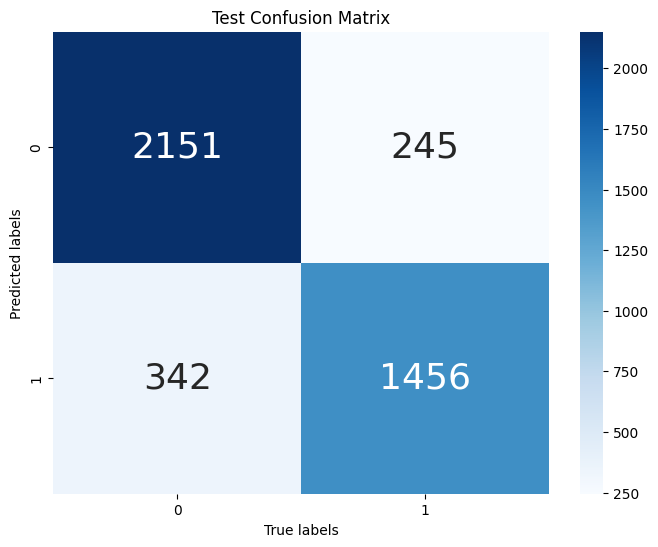

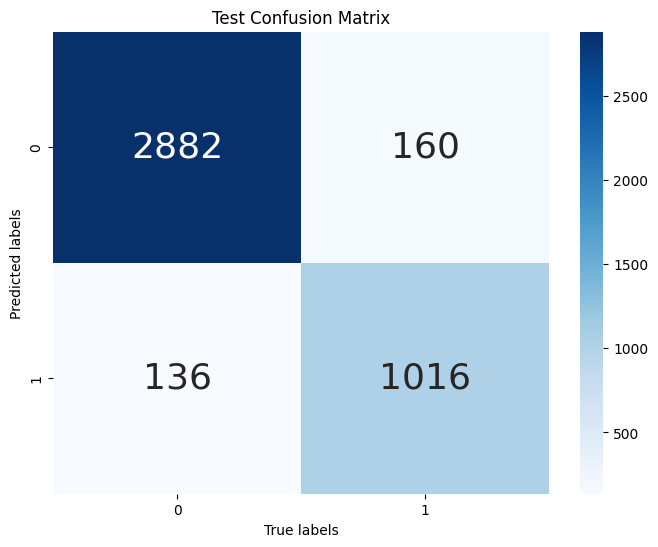

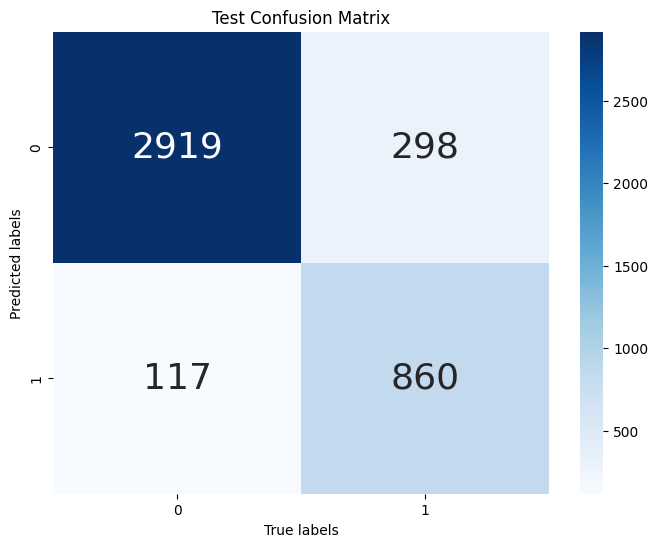

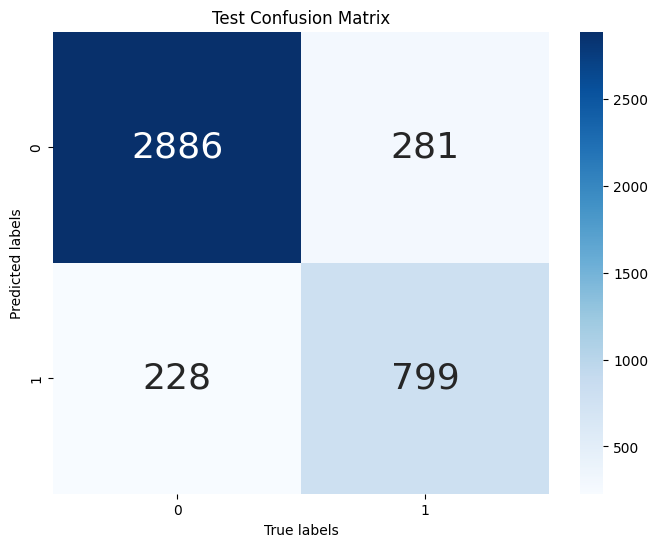

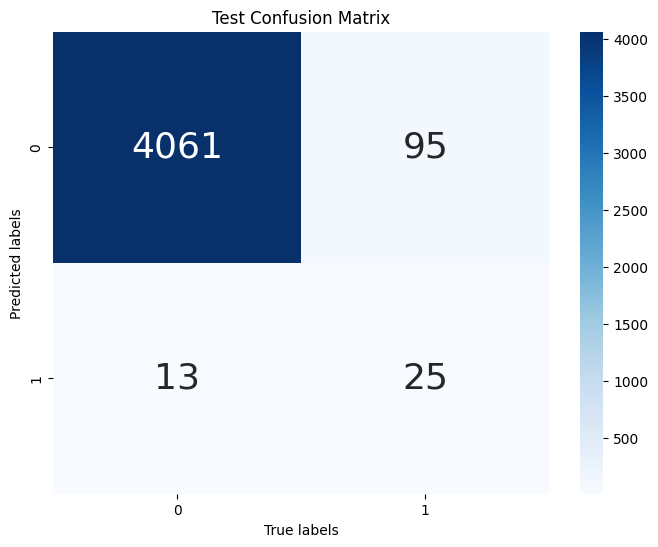

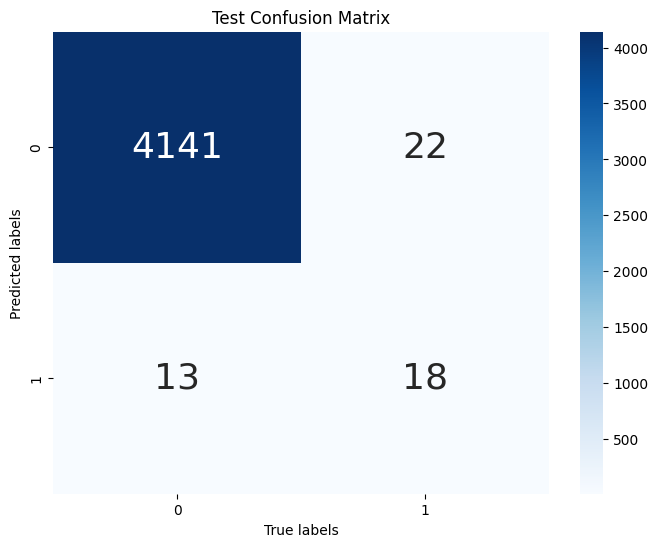

In [49]:
for matrix in confuse_matrix:
    plot_confusion_matrix(matrix)